### Mount Drive

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# %cd '/content/drive/My Drive/SMT202/Reddit Analysis'

### Load Relevant Libraries

In [2]:
!pip install praw
!pip install emot
!pip install pyLDAvis
!pip install wordcloud
!pip install gensim
import praw
from praw.models import MoreComments
import itertools

import pandas as pd
from datetime import datetime

import os
import emot
import re
import string
import nltk
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from functools import reduce, partial

import gensim
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel

import numpy as np
import tqdm

import operator
import time

from pprint import pprint

import pyLDAvis.gensim
import pickle 
import pyLDAvis

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Text Cleaning Functions

In [3]:
def get_date(created):
    '''
    This function is to convert timestamp from UNIX
    '''
    return datetime.fromtimestamp(created)

def emo_to_str(text):
    '''
    This function is to convert emoji/emoticons to text
    '''
    emoji_translation = emot.emoji(text)
    emoticon_translation = emot.emoticons(text)
    # print(emoji_translation)
    emoji_value = len(emoji_translation)
    emoticon_value = len(emoticon_translation)
    if emoji_value > 1 or emoticon_value > 1:  # check if there is emoji or emoticon
        if emoji_value > 1 and emoticon_value > 1: # check if there is both emoji AND emoticon
            location_list = emoji_translation["location"] + emoticon_translation["location"] # list of all emojis and emoticons
            mean_list = emoji_translation["mean"] + emoticon_translation["mean"] # list of meanings of all emojis and emoticons
        elif emoji_value > 1: # check if there is only emoji
            location_list = emoji_translation["location"] # list of all emojis
            mean_list = emoji_translation["mean"] # list of meanings of all emojis
        elif emoticon_value > 1: # check if there is only emoticon
            location_list = emoticon_translation["location"] # list of all emoticons
            mean_list = emoticon_translation["mean"] # list of meanings of all emoticons
        i = 0
        new_text = text
        for each_location in location_list:
            each_meaning = mean_list[i]
            if each_location[0] == each_location[1]:
                new_text = new_text.replace(text[each_location[0]],each_meaning)
            else:
                meanings = mean_list[i].split()
                first_meaning = meanings[0]
                new_text = new_text.replace(text[each_location[0]:each_location[1]],first_meaning)
            i += 1
        return new_text
    else:
        return text

def lower_case(text):
    return text.lower()

def remove_stopwords(text):
    """ Remove Stopwords """
    stop_list = stopwords.words('english')
    stop_list += string.punctuation
    stop_list += ['thing','time','year','way','singapore','china','day','something','point','someone',
                  'month','thing','country','singaporean','group','hand','thanks','word','level','everyone',
                  'mask','eye','city','redit','lot','anyone','reason','haha','yeah','week','thank','article',
                  'bit','post','comment','question','today','malaysia','list','one','part','anything'] #any other stop words
    return [word.strip() for word in text if word.strip() not in stop_list]

def remove_links(text):
    text = re.sub(r'http\S+', '', text) # remove http links
    text = re.sub(r'bit.ly/\S+', '', text) # remove bitly links
    text = re.sub(r'www\S+', '', text) # remove www links
    text = re.sub(r'.*\.com', '', text)
    return text

def remove_symbols(text):
    """ Removes all symbols and keep alphanumerics """
    whitelist = []
    return [re.sub(r'([^a-zA-Z0-9\s]+?)',' ',word) for word in text if word not in whitelist]

def remove_short_words(text,n):
    """ Remove words which are less than or equals to length of n """
    return [word for word in text if len(word) > n]

def remove_apostrophes(text):
    """ Remove words which have 's with a space """
    return [re.sub(r"'s", "",word) for word in text]

def remove_digits(text):
    """ Remove all numbers """
    whitelist = ['covid-19','n95','l1r5','2fa','h2','qoo10','h1n1','m1','f-35','90s','ww2','60s','30+','40s','50+', 
                 '2nd','3rd','4th','1st','5th','7th','13th','20+','h3','20th','10th']
    return [re.sub(r'\d+','',word) for word in text if word not in whitelist]

""" Creates a dictionary with slangs and their equivalents and replaces them """
def replaceSlang(text):
    with open('slangs.txt',encoding="ISO-8859-1") as file:
        slang_map = dict(map(str.strip, line.partition('\t')[::2]) for line in file if line.strip())
    return [slang_map[word] if word in slang_map.keys() else word for word in text]

""" Creates a dictionary with contractions and their equivalents and replaces them """
def replaceContraction(text):
    with open('contractions.txt',encoding="ISO-8859-1") as file:
        contraction_map = dict(map(str.strip, line.partition('\t')[::2]) for line in file if line.strip())
    return [contraction_map[word] if word in contraction_map.keys() else word for word in text]

def replaceElongated(word):
    """ Replaces an elongated word with its basic form, unless the word exists in the lexicon """

    repeat_regexp = re.compile(r'(\w*)(\w)\2(\w*)')
    repl = r'\1\2\3'
    if wordnet.synsets(word):
        return word
    repl_word = repeat_regexp.sub(repl, word)
    if repl_word != word:      
        return replaceElongated(repl_word)
    else:       
        return repl_word

def replaceElongatedText(text):
    return [replaceElongated(word) for word in text]

def removeEmoticons(text):
    """ Removes emoticons from text """
    text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', '', text)
    return text

def replace(word, pos=None):
    """ Creates a set of all antonyms for the word and if there is only one antonym, it returns it """
    antonyms = set()
    for syn in wordnet.synsets(word, pos=pos):
        for lemma in syn.lemmas():
            for antonym in lemma.antonyms():
                antonyms.add(antonym.name())
    if len(antonyms) == 1:
        return antonyms.pop()
    else:
        return None

def replaceNegations(text):
    """ Finds "not" and antonym for the next word and if found, replaces not and the next word with the antonym """
    i, l = 0, len(text)
    words = []
    while i < l:
        word = text[i]
        if word == 'not' and i+1 < l:
            ant = replace(text[i+1])
            if ant:
                words.append(ant)
                i += 2
                continue
        words.append(word)
        i += 1
    return words

def remove_multispaces(text):
    """ Replace multiple spaces with only 1 space """
    return [re.sub(r' +', " ",word) for word in text]

def keep_alphanum(text):
    """ Keep Alphanumeric characters """
    return [word for word in text if word.isalnum()]

def remove_duplicates_in_sentence(text):
    """ Remove consecutive words in a sentence"""
    return re.sub(r'\b(\w+)( \1\b)+', r'\1', text)

def normalize_word(text):
    """ Own mapping function """
    replacement_dict = {}

    text = [replacement_dict[word.strip()] if word.strip() in replacement_dict.keys() else word.strip() for word in text]

    return text

def make_best_bigrams(myString):
    tokens = nltk.word_tokenize(myString)
    stop_bigrams = ['parent child','friend family','issue friend','hope job']
    replace_bigrams = {}
    bigram_finder = nltk.collocations.BigramCollocationFinder.from_words(tokens)
    bigrams = bigram_finder.nbest(nltk.collocations.BigramAssocMeasures.chi_sq, 500)
    bigrams = [' '.join(bigram) for bigram in bigrams]
    bigrams = [bigram for bigram in bigrams if bigram not in stop_bigrams]
    return [replace_bigrams[bigram] if bigram in replace_bigrams.keys() else bigram for bigram in bigrams]

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('N'):
        return wordnet.NOUN
    else:          
        return None

def lemmatize_words(text):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    # Pos tagging
    nltk_tagged = nltk.pos_tag(text)  

    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
        
    # lemmatizing 
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is not None:
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))

    return (lemmatized_sentence)

def clean_text(texts):
    new_texts = [lower_case(str(text)) for text in texts]
    new_texts = [remove_links(text) for text in new_texts]
    new_texts = [removeEmoticons(text) for text in new_texts]
    new_texts = [nltk.word_tokenize(str(text)) for text in new_texts]
    new_texts = [replaceSlang(text) for text in new_texts]
    new_texts = [replaceContraction(text) for text in new_texts]
    new_texts = [normalize_word((text)) for text in new_texts]
    new_texts = [remove_apostrophes((text)) for text in new_texts]
    new_texts = [replaceElongatedText((text)) for text in new_texts]
    new_texts = [remove_digits((text)) for text in new_texts]
    new_texts = [remove_symbols((text)) for text in new_texts]
    new_texts = [replaceNegations(text) for text in new_texts]
    new_texts = [keep_alphanum(text) for text in new_texts]
    new_texts = [lemmatize_words(text) for text in new_texts]
    new_texts = [remove_multispaces(text) for text in new_texts]
    new_texts = [remove_short_words(text,2) for text in new_texts]
    new_texts = [normalize_word((text)) for text in new_texts]
    new_texts = [remove_stopwords(text) for text in new_texts]
    new_texts = [' '.join(text) for text in new_texts]
    new_texts = [remove_duplicates_in_sentence(str(text)) for text in new_texts]

    return new_texts

<>:110: DeprecationWarning: invalid escape sequence \)
<>:110: DeprecationWarning: invalid escape sequence \)
<>:110: DeprecationWarning: invalid escape sequence \)
<ipython-input-3-a1c56164cfe8>:110: DeprecationWarning: invalid escape sequence \)
  text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', '', text)


### Generate search keywords & get current date

In [4]:
date = datetime.date(datetime.now())

keywords =  ['stress', 'pressure', 'mental tension', 'mental strain', 'overworked', 'frustration', 'tired', 'depressed', 
             'sad', 'dejected', 'despair', 'antidepressant', 'burnout', 'emptiness', 'insomnia', 'depression', 'suicide', 
             'samaritans of singapore', 'sos', 'die', 'burden', 'worthlessness', 'anxiety', 'worry', 'apprehension', 
             'distress', 'panic', 'hyperventilation', 'helpless', 'hyperventilate', 'love for oneself', 'self care', 
             'good social relationships', 'emotional regulations', 'social anxiety', 'mental health', 'mental illness', 
             'able to cope', 'social wellbeing', 'get help', 'healthy thoughts', 'excellent mental health', 'too much work',
             'understanding surroundings', 'level of stress', 'unsound mind', 'pressuring environments', 'well being', 
             'stress management', 'treat yourself', 'no money', 'articulating thoughts', 'emotional wellbeing', 
             'practice care', 'sleep deprivation', 'mentally unwell', 'coping mechanism', 'social stigma', 
             'able to manage emotions', 'mood swings', 'self actualization', 'positive mindset', 'always reach out', 
             'therapy', 'peace', 'crazy', 'stigma', 'imh', 'insane', 'stress-free', 'bullying', 'self-being', 'anger', 
             'undepressed', 'counselling', 'disorder', 'meditation', 'psychological', 'resilience', 'confusion', 
             'psychology', 'contentment', 'struggle', 'bipolar', 'counsellor', 'insecurities', 'self-care', 'sanity', 
             'messy', 'lonely', 'spirituality', 'depress', 'serenity', 'warmth', 'dissatisfaction', 'unanxious']

words = []

for keyword in keywords:
    words = keyword.split()
    for word in words:
        if word not in words:
            words.append(word)

### Redit Crawling

In [5]:
# '''
# Getting Reddit and subreddit instances

# PRAW stands for Python Reddit API Wrapper.

# First, we connect to Reddit by calling the praw.Reddit function and storing it in a variable.

# I’m calling mine reddit. You should pass the following arguments to that function:
# '''

# # reddit = praw.Reddit(client_id='PERSONAL_USE_SCRIPT_14_CHARS', \
# #                      client_secret='SECRET_KEY_27_CHARS ', \
# #                      user_agent='YOUR_APP_NAME', \
# #                      username='YOUR_REDDIT_USER_NAME', \
# #                      password='YOUR_REDDIT_LOGIN_PASSWORD')

# reddit = praw.Reddit(client_id='wsc0taNIsiYsSg', \
#                      client_secret='PGmgeJNivKNmdhWpjqFUxmsRzaU', \
#                      user_agent='SMT202', \
#                      username='delinhquent', \
#                      password='dl95damor')

In [6]:
# subreddit = reddit.subreddit('singapore')

In [7]:
# topics_dict = { "author": [],
#                 "title":[],
#                 "upvotes":[],
#                 "id":[], "url":[],
#                 "comms_num": [],
#                 "created": [],
#                 "body":[],
#                "stickied":[],
#                "upvote_ratio":[],
#                "keyword":[]
#                }

In [8]:
# for keyword in keywords:
#     count = 0
#     for submission in subreddit.search(keyword):
#         if submission.title not in topics_dict['title'] and count <= 100:
#             topics_dict["author"].append(submission.author)
#             topics_dict["title"].append(submission.title)
#             topics_dict["upvotes"].append(submission.score)
#             topics_dict["id"].append(submission.id)
#             topics_dict["url"].append(submission.url)
#             topics_dict["comms_num"].append(submission.num_comments)
#             topics_dict["created"].append(submission.created)
#             topics_dict["body"].append(submission.selftext)
#             topics_dict["stickied"].append(submission.stickied)
#             topics_dict["upvote_ratio"].append(submission.upvote_ratio)
#             topics_dict["keyword"].append(keyword)
#             print(keyword,count)
#             count += 1
#         elif count == 101:
#             keywords.next()
#             continue

In [9]:
# topics_data = pd.DataFrame(topics_dict)

# filename = 'Reddit_Crawled_Threads_' + str(date) + '.csv'
# topics_data.to_csv(filename, index=False)

### Crawl for comments for each threads

In [10]:
# submission_dict = { "id": [],
#                    "title":[],
#                 "url":[],
#                 "comment_id":[],
#                 "author":[],
#                 "comment":[],
#                    "score": [],
#                    "stickied":[],
#                    "keyword": [],
#                   "created":[]
#                }
# available_reddit_titles = []
# for index,row in topics_data.iterrows():
#     submission_id = row['id']
#     submission_url = row['url']
#     submission_title = row['title']
#     submission_keyword = row['keyword']
#     try:
#         submission = reddit.submission(url=submission_url)
#         available_reddit_titles.append(submission_title)
#         submission.comments.replace_more(limit=None)
#         for comment in submission.comments.list():
#             submission_dict['id'].append(submission_id)
#             submission_dict['url'].append(submission_url)
#             submission_dict['title'].append(submission_title)
#             submission_dict['comment_id'].append(comment.parent_id)
#             submission_dict['author'].append(comment.author)
#             submission_dict['comment'].append(comment.body)
#             submission_dict['score'].append(comment.score)
#             submission_dict['stickied'].append(comment.stickied)
#             submission_dict['keyword'].append(submission_keyword)
#             submission_dict['created'].append(comment.created_utc)
#     except:
#         continue

# for index,row in topics_data[topics_data['title'].isin(available_reddit_titles)].iterrows():
#     submission_dict['id'].append(row['id'])
#     submission_dict['url'].append(row['url'])
#     submission_dict['title'].append(row['title'])
#     submission_dict['comment_id'].append(row['id'])
#     submission_dict['author'].append(row['author'])
#     submission_dict['comment'].append(row['body'])
#     submission_dict['score'].append(row['upvotes'])
#     submission_dict['stickied'].append(row['stickied'])
#     submission_dict['keyword'].append(row['keyword'])
#     submission_dict['created'].append(row['created'])

In [11]:
# comment_data = pd.DataFrame(submission_dict)

# _timestamp = comment_data["created"].apply(get_date)

# comment_data = comment_data.assign(timestamp = _timestamp)

# filename = 'Reddit_Crawled_Comments_' + str(date) + '.csv'
# comment_data.to_csv(filename, index=False)

### Text Pre-Processing

#### Load Dataset

In [12]:
# comments_df = pd.read_csv('Reddit_Crawled_Comments_2020-03-15.csv')
# print("Before dropping duplicates and null:", len(comments_df))

# comments_df.drop_duplicates(keep='first', inplace=True)
# comments_df = comments_df[pd.notnull(comments_df['comment'])]
# comments_df = comments_df[~comments_df['comment'].isin(['[deleted]','[removed]'])]
# print("After dropping duplicates, null, [deleted] & [removed]:", len(comments_df))
# display(comments_df)

#### EDA

##### Looking at symbols

In [13]:
# ans = []
# for text in comments_df['comment'].str.replace('\n', ' ').str.replace('\t', ' ').str.lower().str.strip():
#     text = str(text)
#     text = nltk.word_tokenize(text)
#     for word in text:
#         if re.findall('\W\S',word) != []:
#             ans.append(word)

# word_cloud_dict=Counter(ans)
# wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_cloud_dict)

# plt.figure(figsize=(15,8))
# plt.imshow(wordcloud)
# plt.axis("off")
# plt.show()

##### Looking at digits

In [14]:
# ans = []
# for text in comments_df['comment'].str.replace('\n', ' ').str.replace('\t', ' ').str.lower().str.strip():
#     text = str(text)
#     text = nltk.word_tokenize(text)
#     for word in text:
#         if re.findall(r'\d+',word) != []:
#             ans.append(word)

# word_cloud_dict=Counter(ans)
# wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_cloud_dict)

# plt.figure(figsize=(15,8))
# plt.imshow(wordcloud)
# plt.axis("off")
# plt.show()

##### Looks with consecutive characters

In [15]:
# ans = []
# for text in comments_df['comment'].str.replace('\n', ' ').str.replace('\t', ' ').str.lower().str.strip():
#     text = str(text)
#     text = nltk.word_tokenize(text)
#     for word in text:
#         if re.findall(r'([a-z])\1\1+',word) != []:
#             ans.append(word)

# word_cloud_dict=Counter(ans)
# wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_cloud_dict)

# plt.figure(figsize=(15,8))
# plt.imshow(wordcloud)
# plt.axis("off")
# plt.show()

##### Looking at words with length of 2

In [16]:
# ans = []
# for text in comments_df['comment'].str.replace('\n', ' ').str.replace('\t', ' ').str.lower().str.strip():
#     text = str(text)
#     text = nltk.word_tokenize(text)
#     for word in text:
#         if len(word) == 2 and word.isalpha():
#             ans.append(word)

# word_cloud_dict=Counter(ans)
# wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_cloud_dict)

# plt.figure(figsize=(15,8))
# plt.imshow(wordcloud)
# plt.axis("off")
# plt.show()

##### Looking at words with length of 1 and are alphabets

In [17]:
# ans = []
# for text in comments_df['comment'].str.replace('\n', ' ').str.replace('\t', ' ').str.lower().str.strip():
#     text = str(text)
#     text = nltk.word_tokenize(text)
#     for word in text:
#         if len(word) == 1 and word.isalpha():
#             ans.append(word)

# word_cloud_dict=Counter(ans)
# wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_cloud_dict)

# plt.figure(figsize=(15,8))
# plt.imshow(wordcloud)
# plt.axis("off")
# plt.show()

#### Look at Redacted Authors

In [18]:
# comments_df[comments_df.author == '<Redacted>']

# print(len(comments_df[comments_df.author == '<Redacted>']))

#### Cleaning

In [19]:
# comments_df['text'] = comments_df['comment'].str.replace('\n', ' ').str.replace('\t', ' ').str.lower().str.strip()
# comments_df['text'] = clean_text(comments_df['text'])
# # print(list(comments_df['text']))

# display(comments_df)

In [20]:
# print("Before dropping duplicates and null:", len(comments_df))

# comments_df.drop_duplicates('text',keep='first', inplace=True)
# comments_df = comments_df[pd.notnull(comments_df['text'])]
# print("After dropping duplicates & null:", len(comments_df))
# comments_df['temp'] = comments_df.text.str.split(" ")
# comments_df = comments_df[comments_df.temp.str.len() > 3]
# print("After dropping duplicates, null & length > 3:", len(comments_df))

# display(comments_df)
# filename = 'Reddit_Crawled_Comments_Cleaned_' + str(date) + '.csv'
# comments_df.to_csv(filename, index=False)

### Sentiment

In [21]:
# sid = SentimentIntensityAnalyzer()

# compound = []

# for index,row in comments_df.iterrows():
#     row['comment'] = emo_to_str(row['comment'])
#     comment = str(row['comment'])
#     compound.append(sid.polarity_scores(comment)["compound"])

# comments_df['compound'] = compound
# comments_df.head()

# filename = 'Reddit_Crawled_Comments_Cleaned_Scores_' + str(date) + '.csv'
# comments_df.to_csv(filename, index=False)

### Build Dictionary & additional Text Cleaning

#### Load cleaned Dataset

In [22]:
comments_df = pd.read_csv('Reddit_Crawled_Comments_Cleaned_Scores_2020-03-18.csv')
# comments_df = pd.read_csv('Reddit_Crawled_Comments_Cleaned_2020-03-18.csv')
comments_df

,id,title,url,comment_id,author,comment,score,stickied,keyword,created,timestamp,text,temp,compound
0,fii8mf,Is life a constant series of stress in Singapo...,https://www.reddit.com/r/singapore/comments/fi...,t3_fii8mf,01100001_01101110,"Rant: Hey, no offense intended here, but for m...",57,False,stress,1584205560,14/3/2020 17:06,rant offense issue sense singa effect quality ...,"['rant', 'offense', 'issue', 'sense', 'singa',...",0.9970
1,fii8mf,Is life a constant series of stress in Singapo...,https://www.reddit.com/r/singapore/comments/fi...,t3_fii8mf,Taellion,I know a lot of my friends either get a weeken...,13,False,stress,1584192345,14/3/2020 13:25,friend hobby quit job chill occupation,"['friend', 'hobby', 'quit', 'job', 'chill', 'o...",0.8051
2,fii8mf,Is life a constant series of stress in Singapo...,https://www.reddit.com/r/singapore/comments/fi...,t3_fii8mf,silentscope90210,It's about not having too many things on your ...,15,False,stress,1584192700,14/3/2020 13:31,plate paycheck child transport condo loan card,"['plate', 'paycheck', 'child', 'transport', 'c...",-0.5106
3,erblrv,Do I need a high stress job to earn more??,https://www.reddit.com/r/singapore/comments/er...,t3_erblrv,ViolaceaIndigo,"A high in demand job earns more, not a high st...",47,False,stress,1579521466,20/1/2020 11:57,demand job stress job plenty stress environment,"['demand', 'job', 'stress', 'job', 'plenty', '...",0.5707
4,erblrv,Do I need a high stress job to earn more??,https://www.reddit.com/r/singapore/comments/er...,t3_erblrv,gmdotes,"if you are capable enough, yes, you can make l...",14,False,stress,1579518322,20/1/2020 11:05,industry demand mine freelance english equival...,"['industry', 'demand', 'mine', 'freelance', 'e...",0.9479
5,erblrv,Do I need a high stress job to earn more??,https://www.reddit.com/r/singapore/comments/er...,t3_erblrv,khaosdd,"I've learned in my career life your mindset, w...",22,False,stress,1579519550,20/1/2020 11:25,career mindset answer demand industry say faci...,"['career', 'mindset', 'answer', 'demand', 'ind...",0.8680
6,erblrv,Do I need a high stress job to earn more??,https://www.reddit.com/r/singapore/comments/er...,t1_ff2ql2t,elpipita20,>Your personal integrity and responsibility to...,25,False,stress,1579522877,20/1/2020 12:21,integrity responsibility home regardless thru ...,"['integrity', 'responsibility', 'home', 'regar...",0.2168
7,erblrv,Do I need a high stress job to earn more??,https://www.reddit.com/r/singapore/comments/er...,t1_ff2r5yz,fijimermaidsg,I remember when the uncles in the next office ...,23,False,stress,1579529445,20/1/2020 14:10,uncle blind lunch tea,"['uncle', 'blind', 'lunch', 'tea']",0.0000
8,f1j3ox,"People who have spent time overseas, is the re...",https://www.reddit.com/r/singapore/comments/f1...,t3_f1j3ox,Snowstormzzz,No. Singapore is just lucky that we do not get...,39,False,stress,1581304921,10/2/2020 3:22,disaster mentality hurricane typhoon,"['disaster', 'mentality', 'hurricane', 'typhoon']",0.3430
9,f1j3ox,"People who have spent time overseas, is the re...",https://www.reddit.com/r/singapore/comments/f1...,t3_f1j3ox,KenjiZeroSan,Everywhere is the same even in Japan. People w...,99,False,stress,1581302737,10/2/2020 2:45,japan victual lawson famimart typhoon beacon k...,"['japan', 'victual', 'lawson', 'famimart', 'ty...",0.4404


#### Uni vs Bi vs Tri -grams

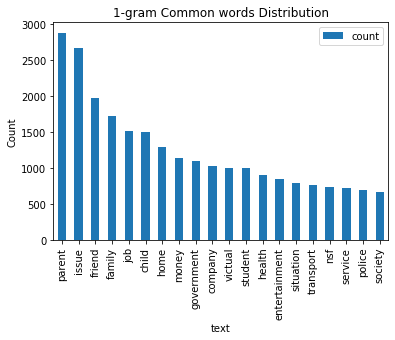

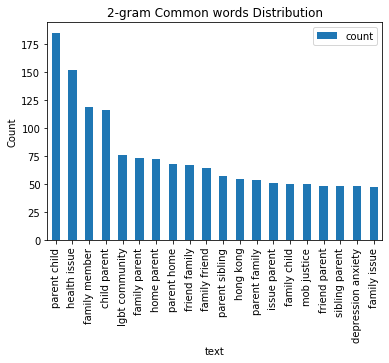

In [23]:
def get_top_n_gram(corpus,a,n=None):
    vec = CountVectorizer(ngram_range=(a,a)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

comments_df = comments_df[pd.notnull(comments_df['text'])]
for i in range(1,3):
    common_words = get_top_n_gram(comments_df['text'],i,20)
    df_commonwords = pd.DataFrame(common_words, columns = ['text' , 'count'])

    ax = df_commonwords.plot(
        kind='bar',
        x = 'text',
        y = 'count',
        title=str(i)+'-gram Common words Distribution')
    ax.set_ylabel("Count")
    plt.show()

#### Build Dictionary

In [24]:
texts = [nltk.word_tokenize(text) for text in comments_df['text']]
bigrams = [make_best_bigrams(text) for text in comments_df['text']]

documents = [texts[i] + bigrams[i] for i in range(len(texts))]

dictionary = gensim.corpora.Dictionary(documents)

# documents = texts

dictionary = gensim.corpora.Dictionary(texts)
print('Unigram Size before filtering:', len(dictionary))
dictionary.filter_extremes(no_below=30,no_above=0.8)
print('Unigram Size aftering filtering:', len(dictionary))

dictionary.add_documents(bigrams)
print('Total Vocabulary Size before filtering:', len(dictionary))

dictionary.filter_extremes(no_below=30,no_above=0.8)
print('Total Vocabulary Size after filtering:', len(dictionary), '\n')

corpus = [dictionary.doc2bow(text) for text in documents]
corpus[0]

Unigram Size before filtering: 16444
Unigram Size aftering filtering: 1154
Total Vocabulary Size before filtering: 162622
Total Vocabulary Size after filtering: 1182 



[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 2),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 2),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 2),
 (18, 1)]

### Finding number of topics

In [25]:
##### Can take a long time to run.
limit=11
start=2
step=1
start_time = time.process_time()
model_list = []

score = {}
previous_coherence = None
coherence_values = []

for num_topic in range(start, limit, step):
    ldamodel = gensim.models.ldamodel.LdaModel(
                corpus, num_topics = num_topic, id2word=dictionary, passes=10, random_state= 0,
                alpha='auto',eta='auto')
    model_list.append(ldamodel)
    log_perplexity = ldamodel.log_perplexity(corpus)
    perplexity = 2**(-log_perplexity)

    # Compute Coherence Score
    coherencemodel = CoherenceModel(model=ldamodel, texts=documents, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherencemodel.get_coherence()
    if previous_coherence == None:
        score[num_topic] = coherence_lda
        difference = 0
    else:
        difference = coherence_lda-previous_coherence
        score[num_topic] = coherence_lda
    print("Number of topics: {}\nCoherence Value: {}, Difference in Coherence: {}\n".format(num_topic,coherence_lda,difference))
    previous_coherence = coherence_lda
    coherence_values.append(coherence_lda)

print('Run Time: {} seconds'.format(str((time.process_time() - start_time))))

Number of topics: 2
Coherence Value: 0.5734004656014762, Difference in Coherence: 0

Number of topics: 3
Coherence Value: 0.626201611192735, Difference in Coherence: 0.05280114559125881

Number of topics: 4
Coherence Value: 0.5867453634918174, Difference in Coherence: -0.0394562477009176

Number of topics: 5
Coherence Value: 0.5787423912369529, Difference in Coherence: -0.00800297225486446

Number of topics: 6
Coherence Value: 0.558290692391811, Difference in Coherence: -0.020451698845141975

Number of topics: 7
Coherence Value: 0.551142782399111, Difference in Coherence: -0.007147909992699986

Number of topics: 8
Coherence Value: 0.5534716532176642, Difference in Coherence: 0.0023288708185532636

Number of topics: 9
Coherence Value: 0.5473671111103283, Difference in Coherence: -0.0061045421073359085

Number of topics: 10
Coherence Value: 0.49491406271139926, Difference in Coherence: -0.05245304839892906

Run Time: 368.34799610100004 seconds


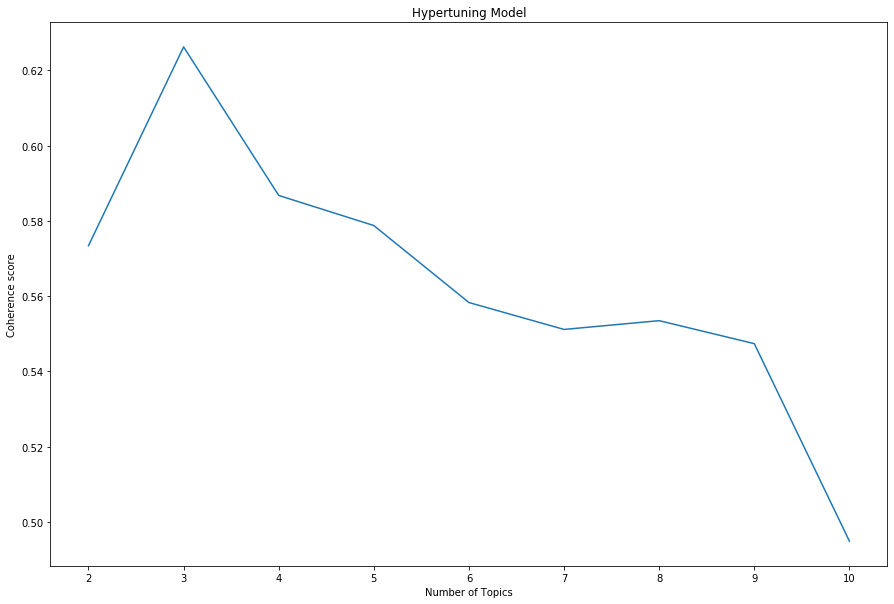

In [26]:
# Show graph
x = range(len(model_list))
plt.figure(figsize=(15, 10))
plt.plot(list(score.keys()), coherence_values)
plt.title("Hypertuning Model")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.savefig('hypertune_chart.png')
plt.show()

#### Check Topic Distribution and do further cleaning

In [27]:
index = 0
topics_words = []
for num_topic, scores in score.items():
    print("Number of topics: {}\n Coherence Value: {}".format(num_topic,scores))
    for num ,topic in model_list[index].show_topics(formatted=True, num_topics=num_topic, num_words=10):
        print(str(num)+": "+ topic)
    for num ,topic in model_list[index].show_topics(formatted=False, num_topics=num_topic, num_words=10):
        topic_words = [word[0] for word in topic]
        topics_words += topic_words
    index += 1
    print()

unique_words = set(topic_words)
word_count = {}
for word in unique_words:
    word_count[word] = topics_words.count(word)
print("\nTop Word Counts")
print(sorted(word_count.items(), key=lambda item: item[1], reverse=True))

Number of topics: 2
 Coherence Value: 0.5734004656014762
0: 0.017*"job" + 0.014*"government" + 0.013*"company" + 0.011*"issue" + 0.011*"entertainment" + 0.010*"victual" + 0.010*"money" + 0.009*"home" + 0.008*"transport" + 0.008*"friend"
1: 0.035*"parent" + 0.033*"issue" + 0.025*"health" + 0.023*"family" + 0.020*"friend" + 0.018*"child" + 0.013*"student" + 0.012*"doctor" + 0.011*"depression" + 0.010*"condition"

Number of topics: 3
 Coherence Value: 0.626201611192735
0: 0.027*"issue" + 0.018*"government" + 0.016*"society" + 0.011*"police" + 0.011*"victim" + 0.010*"entertainment" + 0.009*"punishment" + 0.009*"lgbt" + 0.009*"policy" + 0.008*"community"
1: 0.055*"health" + 0.034*"issue" + 0.027*"doctor" + 0.024*"depression" + 0.022*"condition" + 0.022*"nsf" + 0.021*"illness" + 0.017*"psychiatrist" + 0.017*"anxiety" + 0.015*"hospital"
2: 0.039*"parent" + 0.028*"friend" + 0.026*"family" + 0.022*"job" + 0.021*"child" + 0.018*"home" + 0.015*"company" + 0.014*"money" + 0.013*"student" + 0.012*"

### Select best number of topics & train final LDA Model

In [28]:
best_model = max(enumerate(coherence_values), key=operator.itemgetter(1))
index = best_model[0]

optimal_model = model_list[index]
optimal_model.save('best_lda_after_filtering.model')

In [29]:
# # later on, load trained model from file
optimal_model =  gensim.models.LdaModel.load('best_lda_after_filtering.model')

doc_lda = optimal_model[corpus]


print(doc_lda)

### Assignment of topics

In [30]:
topic_composition = {0:"Government/Society Related",1:"Health Related",2:"Personal Life Related"}
topics = []
count = 0

for results in doc_lda:
    max_score = 0
    topic = 0
    for result in results:
        if result[1] > max_score:
            max_score = result[1]
            topic = result[0]
#     topics.append(topic_composition[topic])
    topics.append(topic_composition[topic])
# cleaned_df['topic'] = topics
comments_df['topic'] = topics
# filename = 'Reddit_Crawled_Comments_Cleaned_Scores_based_on_Threads_with_Topics_' + str(date) + '.csv'
# cleaned_df.to_csv(filename, index=False)
# cleaned_df.head()
filename = 'Reddit_Crawled_Comments_Cleaned_Scores_with_Topics_after_filtering_' + str(date) + '.csv'
comments_df.to_csv(filename, index=False)
comments_df.head()

,id,title,url,comment_id,author,comment,score,stickied,keyword,created,timestamp,text,temp,compound,topic
0,fii8mf,Is life a constant series of stress in Singapo...,https://www.reddit.com/r/singapore/comments/fi...,t3_fii8mf,01100001_01101110,"Rant: Hey, no offense intended here, but for m...",57,False,stress,1584205560,14/3/2020 17:06,rant offense issue sense singa effect quality ...,"['rant', 'offense', 'issue', 'sense', 'singa',...",0.9970,Personal Life Related
1,fii8mf,Is life a constant series of stress in Singapo...,https://www.reddit.com/r/singapore/comments/fi...,t3_fii8mf,Taellion,I know a lot of my friends either get a weeken...,13,False,stress,1584192345,14/3/2020 13:25,friend hobby quit job chill occupation,"['friend', 'hobby', 'quit', 'job', 'chill', 'o...",0.8051,Personal Life Related
2,fii8mf,Is life a constant series of stress in Singapo...,https://www.reddit.com/r/singapore/comments/fi...,t3_fii8mf,silentscope90210,It's about not having too many things on your ...,15,False,stress,1584192700,14/3/2020 13:31,plate paycheck child transport condo loan card,"['plate', 'paycheck', 'child', 'transport', 'c...",-0.5106,Personal Life Related
3,erblrv,Do I need a high stress job to earn more??,https://www.reddit.com/r/singapore/comments/er...,t3_erblrv,ViolaceaIndigo,"A high in demand job earns more, not a high st...",47,False,stress,1579521466,20/1/2020 11:57,demand job stress job plenty stress environment,"['demand', 'job', 'stress', 'job', 'plenty', '...",0.5707,Personal Life Related
4,erblrv,Do I need a high stress job to earn more??,https://www.reddit.com/r/singapore/comments/er...,t3_erblrv,gmdotes,"if you are capable enough, yes, you can make l...",14,False,stress,1579518322,20/1/2020 11:05,industry demand mine freelance english equival...,"['industry', 'demand', 'mine', 'freelance', 'e...",0.9479,Personal Life Related


### Load topic-assigned dataset

In [31]:
comments_topic_df = pd.read_csv('Reddit_Crawled_Comments_Cleaned_Scores_with_Topics_after_filtering_2020-03-18.csv')
comments_topic_df.head()

,id,title,url,comment_id,author,comment,score,stickied,keyword,created,timestamp,text,temp,compound,topic
0,fii8mf,Is life a constant series of stress in Singapo...,https://www.reddit.com/r/singapore/comments/fi...,t3_fii8mf,01100001_01101110,"Rant: Hey, no offense intended here, but for m...",57,False,stress,1584205560,14/3/2020 17:06,rant offense issue sense singa effect quality ...,"['rant', 'offense', 'issue', 'sense', 'singa',...",0.9970,Personal Life Related
1,fii8mf,Is life a constant series of stress in Singapo...,https://www.reddit.com/r/singapore/comments/fi...,t3_fii8mf,Taellion,I know a lot of my friends either get a weeken...,13,False,stress,1584192345,14/3/2020 13:25,friend hobby quit job chill occupation,"['friend', 'hobby', 'quit', 'job', 'chill', 'o...",0.8051,Personal Life Related
2,fii8mf,Is life a constant series of stress in Singapo...,https://www.reddit.com/r/singapore/comments/fi...,t3_fii8mf,silentscope90210,It's about not having too many things on your ...,15,False,stress,1584192700,14/3/2020 13:31,plate paycheck child transport condo loan card,"['plate', 'paycheck', 'child', 'transport', 'c...",-0.5106,Personal Life Related
3,erblrv,Do I need a high stress job to earn more??,https://www.reddit.com/r/singapore/comments/er...,t3_erblrv,ViolaceaIndigo,"A high in demand job earns more, not a high st...",47,False,stress,1579521466,20/1/2020 11:57,demand job stress job plenty stress environment,"['demand', 'job', 'stress', 'job', 'plenty', '...",0.5707,Personal Life Related
4,erblrv,Do I need a high stress job to earn more??,https://www.reddit.com/r/singapore/comments/er...,t3_erblrv,gmdotes,"if you are capable enough, yes, you can make l...",14,False,stress,1579518322,20/1/2020 11:05,industry demand mine freelance english equival...,"['industry', 'demand', 'mine', 'freelance', 'e...",0.9479,Personal Life Related


### Feature Engineering

In [32]:
comment_consolidated_score = comments_topic_df.copy()
comment_consolidated_score['year'] = pd.to_datetime(comment_consolidated_score['timestamp'], errors='coerce').dt.year
comment_consolidated_score['month'] = pd.to_datetime(comment_consolidated_score['timestamp'], errors='coerce').dt.month
comment_consolidated_score.head()

,id,title,url,comment_id,author,comment,score,stickied,keyword,created,timestamp,text,temp,compound,topic,year,month
0,fii8mf,Is life a constant series of stress in Singapo...,https://www.reddit.com/r/singapore/comments/fi...,t3_fii8mf,01100001_01101110,"Rant: Hey, no offense intended here, but for m...",57,False,stress,1584205560,14/3/2020 17:06,rant offense issue sense singa effect quality ...,"['rant', 'offense', 'issue', 'sense', 'singa',...",0.9970,Personal Life Related,2020,3
1,fii8mf,Is life a constant series of stress in Singapo...,https://www.reddit.com/r/singapore/comments/fi...,t3_fii8mf,Taellion,I know a lot of my friends either get a weeken...,13,False,stress,1584192345,14/3/2020 13:25,friend hobby quit job chill occupation,"['friend', 'hobby', 'quit', 'job', 'chill', 'o...",0.8051,Personal Life Related,2020,3
2,fii8mf,Is life a constant series of stress in Singapo...,https://www.reddit.com/r/singapore/comments/fi...,t3_fii8mf,silentscope90210,It's about not having too many things on your ...,15,False,stress,1584192700,14/3/2020 13:31,plate paycheck child transport condo loan card,"['plate', 'paycheck', 'child', 'transport', 'c...",-0.5106,Personal Life Related,2020,3
3,erblrv,Do I need a high stress job to earn more??,https://www.reddit.com/r/singapore/comments/er...,t3_erblrv,ViolaceaIndigo,"A high in demand job earns more, not a high st...",47,False,stress,1579521466,20/1/2020 11:57,demand job stress job plenty stress environment,"['demand', 'job', 'stress', 'job', 'plenty', '...",0.5707,Personal Life Related,2020,1
4,erblrv,Do I need a high stress job to earn more??,https://www.reddit.com/r/singapore/comments/er...,t3_erblrv,gmdotes,"if you are capable enough, yes, you can make l...",14,False,stress,1579518322,20/1/2020 11:05,industry demand mine freelance english equival...,"['industry', 'demand', 'mine', 'freelance', 'e...",0.9479,Personal Life Related,2020,1


### EDA

In [33]:
topics = list(set(comment_consolidated_score['topic']))

#### Calculating Proportion of Unique Users over the years

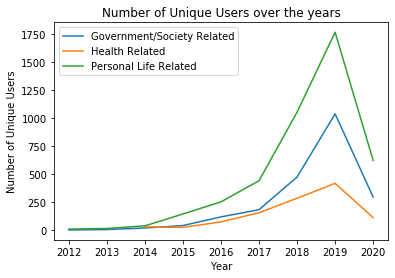

In [34]:
unique_user_df = comment_consolidated_score.groupby(['year','topic'])['author'].nunique().reset_index(name='count')
# display(unique_user_df)

unique_user_year_df = comment_consolidated_score.groupby(['year'])['author'].nunique().reset_index(name='count_year')
# display(unique_user_year_df)

unique_user_df = pd.merge(unique_user_df, unique_user_year_df,how='inner',left_on='year',right_on='year')
unique_user_df['proportion_user'] = unique_user_df['count']/unique_user_df['count_year']
# display(unique_user_df)

fig, ax = plt.subplots()
ax.set_ylabel("Number of Unique Users")
ax.set_xlabel("Year")
ax.set_title("Number of Unique Users over the years")

for key, grp in unique_user_df[unique_user_df['year'] != 2011].groupby(['topic']): 
    ax.plot(grp['year'], grp['count'], label = key)
plt.legend(loc='best')    
plt.show()

#### Calculating Proportion of posts over the years

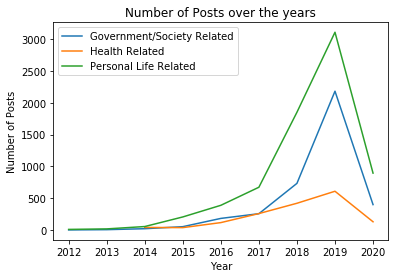

In [35]:
posts_df = comment_consolidated_score.groupby(['year','topic']).size().reset_index(name='count')
posts_df.head()

posts_year_df = comment_consolidated_score.groupby(['year']).size().reset_index(name='count_year')
# display(unique_user_year_df)

posts_df = pd.merge(posts_df, posts_year_df,how='inner',left_on='year',right_on='year')
posts_df['proportion_posts'] = posts_df['count']/posts_df['count_year']
# display(posts_df)

fig, ax = plt.subplots()
ax.set_ylabel("Number of Posts")
ax.set_xlabel("Year")
ax.set_title("Number of Posts over the years")

for key, grp in posts_df[posts_df['year'] != 2011].groupby(['topic']): 
    ax.plot(grp['year'], grp['count'], label = key)
plt.legend(loc='best')    
plt.show()

### Consolidating Scores & EDA

#### Consolidating dataframe by Year

In [36]:
new_score = comment_consolidated_score.copy()
new_score = new_score.groupby(['topic','year']).agg({'compound':'mean'}).rename(columns={'compound': 'average_compound'}).reset_index()
# new_score.head()
new_score = pd.merge(new_score,posts_df,how='left',left_on=['topic','year'],right_on=['topic','year'])
new_score = new_score.drop(columns=['count','count_year'])
new_score = pd.merge(new_score,unique_user_df,how='left',left_on=['topic','year'],right_on=['topic','year'])
new_score = new_score.drop(columns=['count','count_year'])
new_score['normalized_average_compound'] = new_score['average_compound'] * new_score['proportion_posts'] * new_score['proportion_user']
new_score.head()

,topic,year,average_compound,proportion_posts,proportion_user,normalized_average_compound
0,Government/Society Related,2011,0.834300,1.000000,1.000000,0.834300
1,Government/Society Related,2012,-0.229800,0.166667,0.181818,-0.006964
2,Government/Society Related,2013,-0.049350,0.250000,0.294118,-0.003629
3,Government/Society Related,2014,-0.089638,0.179487,0.260274,-0.004188
4,Government/Society Related,2015,0.233021,0.178451,0.215789,0.008973


#### EDA before Standardizing

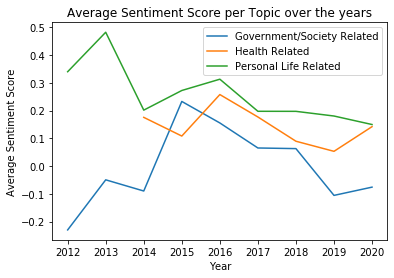

In [37]:
fig, ax = plt.subplots()
ax.set_ylabel("Average Sentiment Score")
ax.set_xlabel("Year")
ax.set_title("Average Sentiment Score per Topic over the years")

for key, grp in new_score[new_score['year'] != 2011].groupby(['topic']): 
    ax.plot(grp['year'], grp['average_compound'], label = key)
plt.legend(loc='best')    
plt.show()

#### EDA after Standardizing

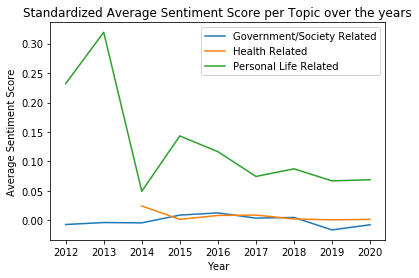

In [38]:
fig, ax = plt.subplots()
ax.set_ylabel("Average Sentiment Score")
ax.set_xlabel("Year")
ax.set_title("Standardized Average Sentiment Score per Topic over the years")

for key, grp in new_score[new_score['year'] != 2011].groupby(['topic']): 
    ax.plot(grp['year'], grp['normalized_average_compound'], label = key)
plt.legend(loc='best')    
plt.show()

#### Visualize using Pyladavis

In [40]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(optimal_model, corpus, dictionary)
# pyLDAvis.save_html(p, 'index.html')

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.123006  0.216223       1        1  51.143265
0     -0.149288 -0.202743       2        1  33.252575
1      0.272294 -0.013479       3        1  15.604165, topic_info=     Category         Freq          Term        Total  loglift  logprob
48    Default  1234.000000        health  1234.000000  30.0000  30.0000
9     Default  2881.000000        parent  2881.000000  29.0000  29.0000
218   Default   598.000000        doctor   598.000000  28.0000  28.0000
6     Default  2938.000000         issue  2938.000000  27.0000  27.0000
47    Default  1909.000000        family  1909.000000  26.0000  26.0000
597   Default   545.000000    depression   545.000000  25.0000  25.0000
22    Default  1528.000000         child  1528.000000  24.0000  24.0000
384   Default   502.000000     condition   502.000000  23.0000  23.0000
167   Default   576.000000           nsf   576.000000  22.0000  22.0000
49    Default  1304.000000          home  1304.000000  21.0000  21.0000
5     Default  2182.000000        friend  2182.000000  20.0000  20.0000
952   Default   462.000000       illness   462.000000  19.0000  19.0000
20    Default  1678.000000           job  1678.000000  18.0000  18.0000
372   Default   767.000000       society   767.000000  17.0000  17.0000
43    Default  1099.000000       company  1099.000000  16.0000  16.0000
295   Default   375.000000  psychiatrist   375.000000  15.0000  15.0000
907   Default   379.000000       anxiety   379.000000  14.0000  14.0000
180   Default  1002.000000         money  1002.000000  13.0000  13.0000
685   Default   338.000000      hospital   338.000000  12.0000  12.0000
301   Default   335.000000    medication   335.000000  11.0000  11.0000
627   Default   334.000000     treatment   334.000000  10.0000  10.0000
70    Default  1017.000000    government  1017.000000   9.0000   9.0000
306   Default   315.000000           imh   315.000000   8.0000   8.0000
68    Default   864.000000       victual   864.000000   7.0000   7.0000
454   Default   508.000000        victim   508.000000   6.0000   6.0000
58    Default   741.000000       service   741.000000   5.0000   5.0000
323   Default   278.000000       patient   278.000000   4.0000   4.0000
431   Default   574.000000        police   574.000000   3.0000   3.0000
40    Default   560.000000          care   560.000000   2.0000   2.0000
786   Default   435.000000    punishment   435.000000   1.0000   1.0000
...       ...          ...           ...          ...      ...      ...
299    Topic3   176.135971        clinic   176.820343   1.8538  -4.8492
1176   Topic3   153.003662  health issue   153.701065   1.8531  -4.9900
309    Topic3   136.299179         nurse   136.973175   1.8527  -5.1056
844    Topic3   131.860535     commander   132.534012   1.8525  -5.1387
1129   Topic3   119.587227     therapist   120.267502   1.8520  -5.2364
1048   Topic3   112.594643           med   113.265343   1.8517  -5.2967
1065   Topic3   111.187309     diagnosis   111.855240   1.8516  -5.3093
955    Topic3   108.168839       soldier   108.869278   1.8512  -5.3368
308    Topic3   106.668213      medicine   107.380196   1.8510  -5.3508
1133   Topic3   100.571526         psych   101.249565   1.8509  -5.4096
926    Topic3   103.665222  consultation   104.376556   1.8508  -5.3793
823    Topic3    94.312531      vocation    95.001984   1.8503  -5.4739
302    Topic3    91.870247          pill    92.561974   1.8501  -5.5001
1131   Topic3    88.148277          ward    88.822365   1.8500  -5.5415
907    Topic3   373.415100       anxiety   379.020813   1.8427  -4.0978
716    Topic3   169.463989    counsellor   170.986099   1.8487  -4.8879
564    Topic3   112.336639       symptom   113.204590   1.8499  -5.2990
198    Topic3   176.508011          army   182.447037   1.8245  -4.8471
203    Topic3   202.887222      training   212.555756   1.8111  -4.7078
167    Topic3  